In [3]:
!pip install torchvision

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import precision_recall_fscore_support as prfs

import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Load MNIST Dataset
Create two classes (label 0 for digits 0-4 and label 1 for digits 5-9), and get the train and test set.

In [4]:
def get_data(n_samples = 10000):
  '''
  Input: n_samples is the total number of samples processed; both train and test data will have n_samples//2 samples.

  Outputs: X_tr, Y_tr are the training images and corresponding (binary) labels; X_te, Y_te are the test images and labels
  '''
  mnist_tr = datasets.MNIST(root = './data', train = True, download = True, transform = transforms.Compose([
                               transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]))
  X_tr = []
  Y_tr = []
  X_te = []
  Y_te = []
  
  for idx, (im, label) in enumerate(mnist_tr):
      if idx == n_samples:
        print(f'Converting image {idx}/{len(mnist_tr)}')
        break
      im_array = np.array(im) 
      binary_label = 0 if label < 5 else 1

      if idx < n_samples//2:
        X_tr.append(im_array)
        Y_tr.append(binary_label)
      else:
        X_te.append(im_array)
        Y_te.append(binary_label)

  X_tr = np.asarray(X_tr)
  Y_tr = np.asarray(Y_tr)
  X_te = np.asarray(X_te)
  Y_te = np.asarray(Y_te)

  return X_tr, X_te, Y_tr, Y_te

# Train and Test a Tree-based Model

In [5]:
def train_model(X_train, t_train, max_depth = 10, min_samples_leaf = 10, criterion = 'gini', 
                seed = 60, model_type = 'DT', n_estimators = 50, max_samples = 0.5, max_features = 100):
  '''
  Inputs: 
    X_train, t_train: Training samples and labels
    max_depth (int): The maximum depth of the decision tree.
    min_samples_leaf (int): The minimum number of samples required to be at a leaf node.
    criterion (string): The function to measure the quality of a split, 
                        can be 'gini' for the Gini impurity, 'log_loss' and 'entropy', both for the information gain
    seed (int): Controls the randomness of the estimator. 
    model_type (string): The type of model being used, can be 'DT' for decision tree, 
                         'RF' for random forest, 'DT_Bagging' for decision tree with bagging and 'AdaBoost' for boosting. 
    n_estimators (int): The number of decision trees in the forest.
    max_samples (int or float): The number of samples to draw from the training set to train each decision tree in the forest.
    max_features (int or float): The number of features to consider when looking for the best split. 

  Output:
    model: The model with the specified parameters, trained on the input data.
  '''
  #Decision Tree
  if model_type == 'DT':
    model = tree.DecisionTreeClassifier(criterion = criterion,
            random_state = seed, max_depth = max_depth, min_samples_leaf = min_samples_leaf)
  
  #Random Forest
  elif model_type == 'RF':
    model = RandomForestClassifier(n_estimators = n_estimators, criterion = criterion,
                                   max_depth = max_depth, min_samples_leaf = min_samples_leaf, 
                                   random_state = seed, max_samples = max_samples, max_features = max_features)
  
  #Decision Tree with Bagging
  elif model_type == 'DT_Bagging':
    model1 = tree.DecisionTreeClassifier(criterion = criterion,
            random_state = seed, max_depth = max_depth, min_samples_leaf = min_samples_leaf)
    model = BaggingClassifier(base_estimator = model1, n_estimators = n_estimators, max_samples = max_samples, random_state = seed)
  
  #Boosting
  elif model_type == 'AdaBoost':
    model1 = tree.DecisionTreeClassifier(criterion = criterion,
            random_state = seed,max_depth = max_depth, min_samples_leaf = min_samples_leaf)
    model = AdaBoostClassifier(base_estimator = model1, n_estimators = n_estimators, random_state = seed)

  model = model.fit(X_train, t_train)
  
  return model


def test_model(X_test, t_test, model, print_flag = False):
  '''
  Inputs: 
    X_test, t_test: Test samples and labels
    model: A trained model.
    print_flag: If True, the test accuracy is printed.

  Output:
    acc: Accuracy of the given model on the test data.
  '''
  acc = model.score(X_test, t_test)
  
  if print_flag:
    print("Accuracy is: ", acc)

  return acc


# Plotting Train and Test Accuracy for different Parameter Values 

In [6]:
def plot_acc(acc_tr, acc_te, par_val, par_name, ymin = 0.75):
  '''
  Inputs: 
    acc_tr: Set of training accuracies (for different parameter values)
    acc_te: Set of test accuracies
    par_val: Set of parameter values
    par_name (string): Name of the parameter
    ymin: minimum value on the y-axis for the plot

  Function: Generates a single plot with the train and test accuracies for different parameter values 
  '''
  fig, ax = plt.subplots()

  ax.plot(par_val, acc_tr, color = 'red', label = 'train')
  ax.plot(par_val, acc_te, color = 'blue', label = 'test')

  ax.legend()
  ax.set_ylim(ymin, 1.0)
  ax.set(xlabel = par_name, ylabel = 'Accuracy')
  ax.set_title(('Accuracy for different values of ' + par_name))

  fig.savefig('Accuracy_' + par_name + '_' + model_type + '_' + str(n_samples) + '.png')

  plt.show()

In [7]:
def get_acc(X_tr, t_tr, X_te, t_te, par_val, par_name, model_type):
   '''
   Inputs: 
     X_tr, t_tr: Training samples and labels
     X_te, t_te: Test samples and labels
     par_val: Set of parameter values
     par_name (string): Name of the parameter
     model_type (string): The type of model being used, can be 'DT' for decision tree, 'RF' for random forest

   Outputs: 
     acc_tr: Set of training accuracies (for different parameter values)
     acc_te: Set of test accuracies
   '''
   acc_tr = []
   acc_te = []
   
   for i in par_val:

     if par_name == 'max_depth':
       model = train_model(X_tr, t_tr, model_type = model_type, max_depth = i, min_samples_leaf = 1) 

     elif par_name == 'min_samples_leaf':
       model = train_model(X_tr, t_tr, model_type = model_type, min_samples_leaf = i, max_depth = 10)

     elif par_name == 'n_estimators':
       model = train_model(X_tr, t_tr, model_type = model_type, n_estimators = i)

     elif par_name == 'max_features':
       model = train_model(X_tr, t_tr, model_type = model_type, max_features = i)

     elif par_name == 'max_samples':
       model = train_model(X_tr, t_tr, model_type = model_type, max_samples = i)

     ac_tr = test_model(X_tr, t_tr, model)
     ac_te = test_model(X_te, t_te, model)

     acc_tr.append(ac_tr)
     acc_te.append(ac_te)

   return np.array(acc_tr), np.array(acc_te)


In [8]:
def check_behaviour(X_tr, X_te, y_tr, y_te, vals, name, model_type, ylim = 0.75):
  # get train and test accuracies for different parameter values
  acc_tr, acc_te = get_acc(X_tr, y_tr, X_te, y_te, par_val=vals, par_name=name, model_type = model_type)
  # plot the train and test accuracies 
  plot_acc(acc_tr, acc_te, vals, name, ylim)
  

# Get train and test data

In [9]:
# Train and test data with 4000 samples each (Used for Parts 1-5)
n_samples = 8000
X_tr, X_te, y_tr8, y_te8 = get_data(n_samples = n_samples)

#flatten the images into 1D inputs for tree-based methods
X_tr8 = X_tr.reshape((n_samples//2, -1)) 
X_te8 = X_te.reshape((n_samples//2, -1))

100%|███████████████████████████| 9912422/9912422 [00:00<00:00, 11710636.67it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|███████████████████████████████| 28881/28881 [00:00<00:00, 24125810.36it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|████████████████████████████| 1648877/1648877 [00:00<00:00, 7467202.42it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████████████████████████████| 4542/4542 [00:00<00:00, 2505000.50it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Converting image 8000/60000


In [10]:
# Train and test data with 1000 samples each (Used for Parts 3-5)
n_samples = 2000
X_tr, X_te, y_tr2, y_te2 = get_data(n_samples = n_samples)

#flatten the images into 1D inputs for tree-based methods
X_tr2 = X_tr.reshape((n_samples//2, -1))
X_te2 = X_te.reshape((n_samples//2, -1))

Converting image 2000/60000


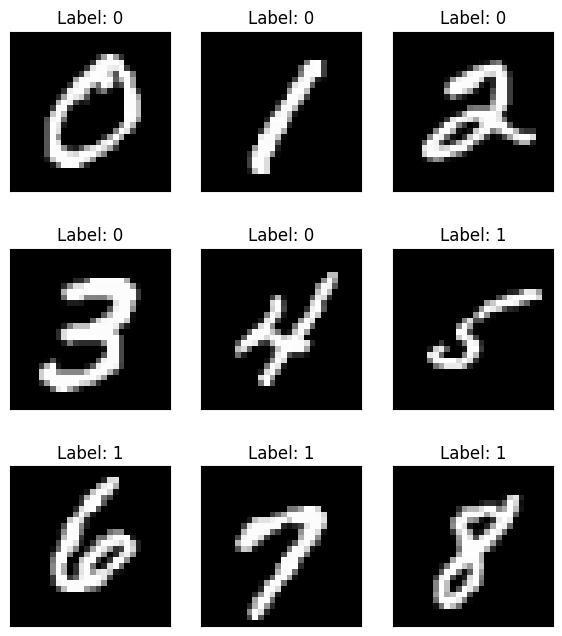

In [11]:
# plot images of digits from the dataset

def plot_dataset_digits(X_tr, y_tr):
  fig = plt.figure(figsize=(7, 8))
  columns = 3
  rows = 3

  ax = []

  for i in range(columns * rows):
    img = X_tr[2*i+1].reshape((28,28))
    label = y_tr[2*i+1]
    
    ax.append(fig.add_subplot(rows, columns, i + 1))
    ax[-1].set_title("Label: " + str(label))  
    plt.imshow(img, cmap='gray', vmin=np.min(X_tr), vmax=np.max(X_tr))
    plt.xticks([])
    plt.yticks([])

  plt.show()  

plot_dataset_digits(X_tr8, y_tr8)

# Check the effect of different hyperparameters 
(Parts 1-5)

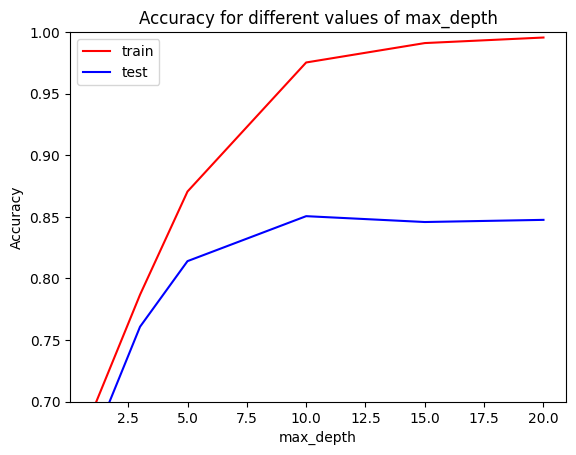

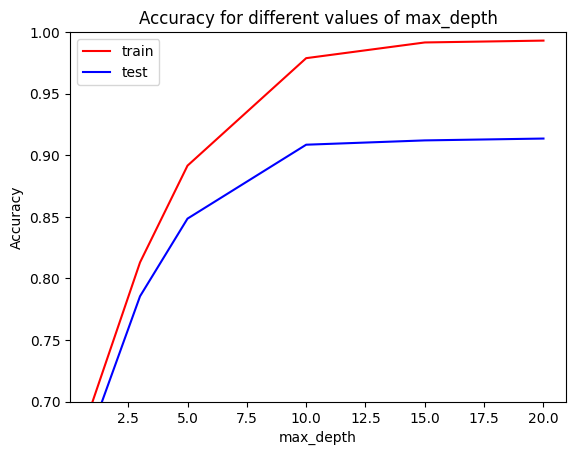

In [12]:
# Part 1: Effect of max_depth

model_type = 'DT'
name = 'max_depth'
vals = [1, 3, 5, 10, 15, 20]
check_behaviour(X_tr8, X_te8, y_tr8, y_te8, vals, name, model_type, ylim = 0.7)

model_type = 'RF'
name = 'max_depth'
vals = [1, 3, 5, 10, 15, 20]
check_behaviour(X_tr8, X_te8, y_tr8, y_te8, vals, name, model_type, ylim = 0.7)


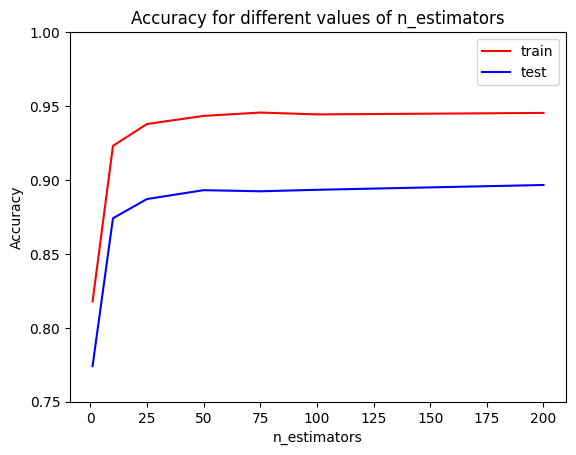

In [13]:
# Part 2: Effect of n_estimators

model_type = 'RF'
name = 'n_estimators'
vals = [1, 10, 25, 50, 75, 100, 200] 
check_behaviour(X_tr8, X_te8, y_tr8, y_te8, vals, name, model_type)

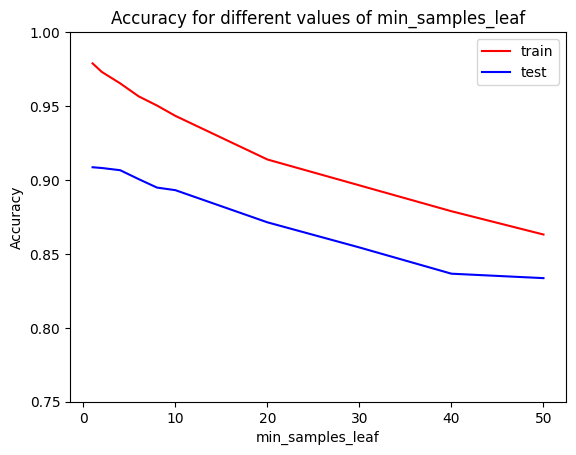

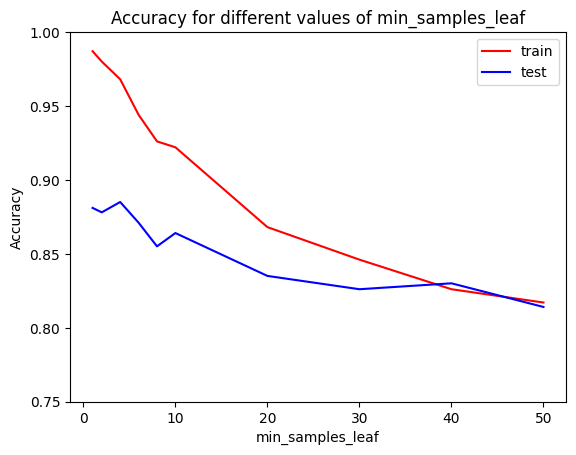

In [14]:
# Part 3: Effect of min_samples_leaf

model_type = 'RF'
name = 'min_samples_leaf'
vals = [1, 2, 4, 6, 8, 10, 20, 30, 40, 50] 
check_behaviour(X_tr8, X_te8, y_tr8, y_te8, vals, name, model_type)

name = 'min_samples_leaf'
vals = [1, 2, 4, 6, 8, 10, 20, 30, 40, 50] 
check_behaviour(X_tr2, X_te2, y_tr2, y_te2, vals, name, model_type)

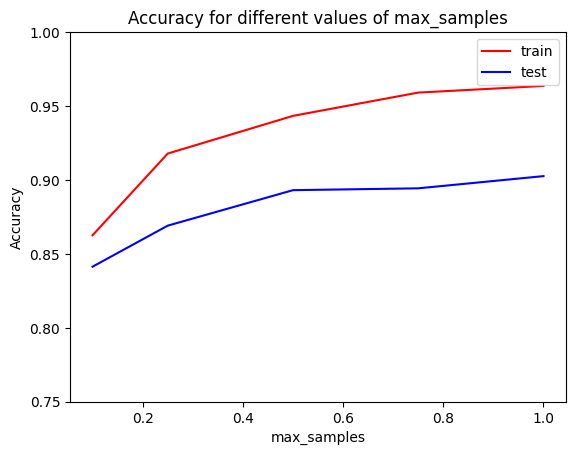

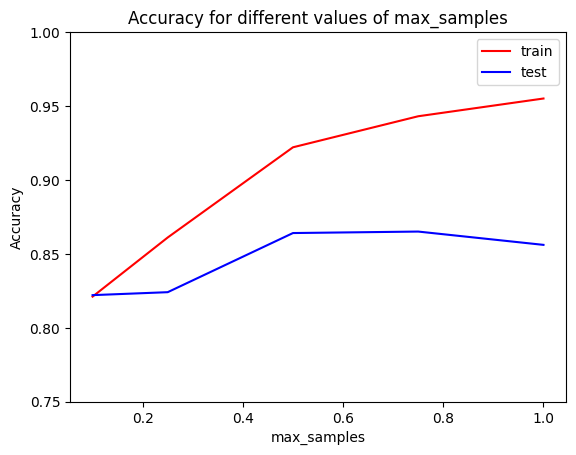

In [15]:
# Part 4: Effect of max_samples

model_type = 'RF'
name = 'max_samples'
vals = [0.1, 0.25, 0.5, 0.75, 1.0] 
check_behaviour(X_tr8, X_te8, y_tr8, y_te8, vals, name, model_type)

name = 'max_samples'
vals = [0.1, 0.25, 0.5, 0.75, 1.0] 
check_behaviour(X_tr2, X_te2, y_tr2, y_te2, vals, name, model_type)

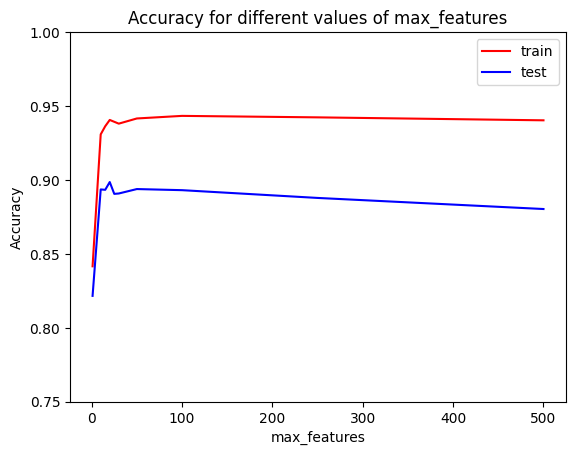

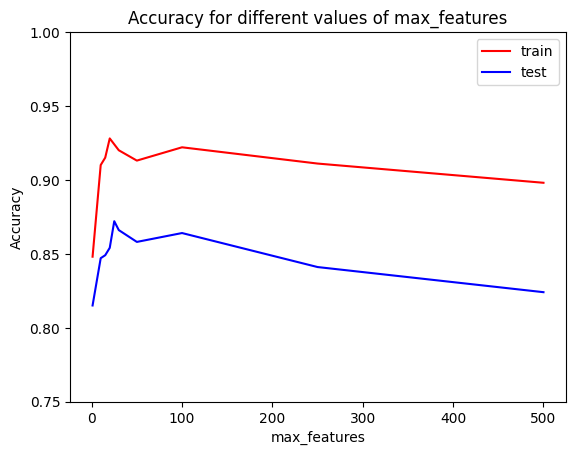

In [16]:
# Part 5: Effect of max_features

model_type = 'RF'
name = 'max_features'
vals = [1, 10, 15, 20, 25, 30, 50, 100, 250, 500] 
check_behaviour(X_tr8, X_te8, y_tr8, y_te8, vals, name, model_type)

name = 'max_features'
vals = [1, 10, 15, 20, 25, 30, 50, 100, 250, 500] 
check_behaviour(X_tr2, X_te2, y_tr2, y_te2, vals, name, model_type)

# Visualize Feature Importances

(Part 6) Visualize the feature importances of a random forest model trained for the binary classification task on the MNIST dataset. 

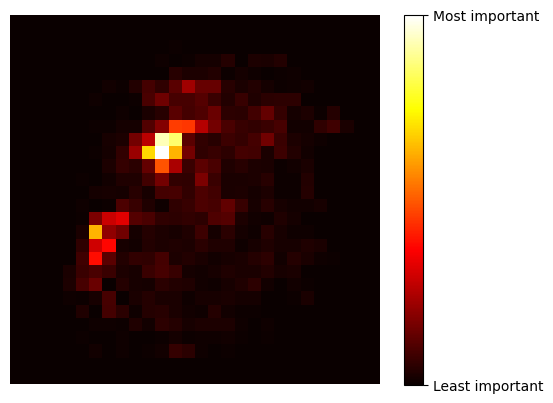

In [17]:
# Part 6
# Based on https://github.com/probml/pyprobml/blob/master/notebooks/book1/18/rf_feature_importance_mnist.ipynb

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.figure()
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

# Train a random forest model for binary classification on MNIST, with a fixed set of parameter values
model = train_model(X_tr8, y_tr8, model_type = 'RF')
test_model(X_tr8, y_tr8, model)
test_model(X_te8, y_te8, model)

# Plot the feature importances
plot_digit(model.feature_importances_)
cbar = plt.colorbar(ticks=[model.feature_importances_.min(), model.feature_importances_.max()])
cbar.ax.set_yticklabels(['Least important', 'Most important'])
plt.savefig("rf_feature_importance_mnist.png", dpi=300)
plt.show()